# IMPORT

In [53]:
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import ot 

## Surf

In [2]:
#Amazon
A_surf = loadmat('surf/amazon.mat')
X_a_surf = A_surf['fts']
Y_a_surf = A_surf['labels']

#Caltech
C_surf = loadmat('surf/caltech10.mat')
X_c_surf = C_surf['fts']
Y_c_surf = C_surf['labels']

# Webcam
W_surf = loadmat('surf/webcam.mat')
X_w_surf = W_surf['fts']
Y_w_surf = W_surf['labels']

# Dslr
D_surf = loadmat('surf/dslr.mat')
X_d_surf = D_surf['fts']
Y_d_surf = D_surf['labels']


In [3]:
print(X_w_surf.shape)
print(Y_w_surf.shape)
print(X_d_surf.shape)
print(Y_d_surf.shape)

(295, 800)
(295, 1)
(157, 800)
(157, 1)


# Subspace Alignement

## Without optimal transport

In [4]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_w_surf, Y_w_surf.ravel())
print("The accuracy is "+str(knn.score(X_d_surf, Y_d_surf)*100)+"%")

The accuracy is 56.05095541401274%


/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


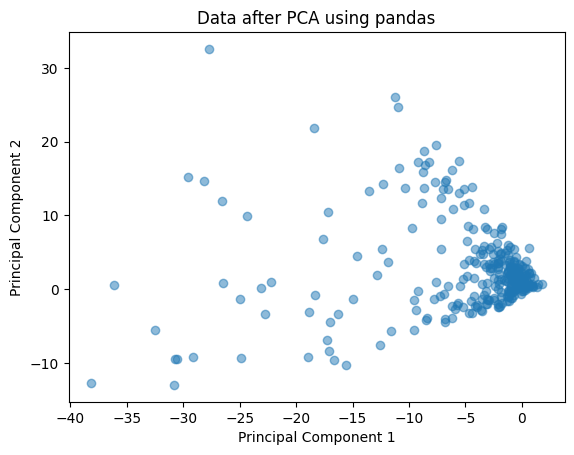

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_w_surf)
# Calculate the covariance matrix
cov_matrix = df.cov()

# Get the eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]

# Transform the data
X_w_surf_pandas = np.dot(X_w_surf, sorted_eigenvectors)

# Visualize the transformed data
plt.scatter(X_w_surf_pandas[:, 0], X_w_surf_pandas[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data after PCA using pandas')
plt.show()


In [7]:
for i in range(len(sorted_eigenvalue)):
    sorted_eigenvalue[i]

In [8]:
np.sum(abs(sorted_eigenvalue)>0.0001)

294

In [38]:
def sub_align(S,S_y,T, T_y, stratified=True ):
    """ INPUT: S is the source features, S_y is the source label, T is the target label, T_y is the target features
        OUTPUT: list_score is a list with the average score of crossvalidation
                best_d is the dimension with the best average score
                score_in_target is the score in the aligend space using the best_d
                score_in_baseline is the 1-KNN only using the source data to classify the target label"""
    #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    list_score = []

    max_d=min([S.shape[0],S.shape[1],T.shape[0]])
    if stratified==True:
        folding = StratifiedKFold(5,shuffle=True, random_state=42)
    else:
        folding = KFold(5, shuffle=True, random_state=42)

    for d in range(1,max_d+1):
        pca = PCA(n_components=d, svd_solver='full')
        
        pca.fit(S)
        Xs=pca.components_.T
        
        pca.fit(T)
        Xt=pca.components_.T
        
        Xa=Xs@Xs.T@Xt
        Sa=S@Xa
        #St=T@Xt

        knn = KNeighborsClassifier(n_neighbors=1)
        #clf = fit.SVC(kernel='linear', C=1, random_state=42)
        scores = cross_val_score(knn, Sa, S_y.ravel(), cv=folding )
        avescore = np.average(scores)
        #print(f'd {d} and score {scores}')
        list_score.append(avescore)
        best_d = np.argmax(np.asarray(list_score))
    
    pca = PCA(n_components=best_d)
        
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    Sa=S@Xa
    St=T@Xt
    knn.fit(Sa,S_y.ravel())
    score_in_target = knn.score(St, T_y.ravel())

    knn_baseline = KNeighborsClassifier(n_neighbors=1)
    knn_baseline.fit(S, S_y.ravel() )
    score_in_baseline = knn_baseline.score(T, T_y.ravel())
   
    return list_score, best_d, score_in_target, score_in_baseline





In [39]:
list_score_w_to_d, best_d_w_to_d, score_in_target_w_to_d, score_in_baseline_w_to_d = sub_align(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
list_score_w_to_c, best_d_w_to_c, score_in_target_w_to_c, score_in_baseline_w_to_c = sub_align(X_w_surf,Y_w_surf,X_c_surf,Y_c_surf)
list_score_w_to_a, best_d_w_to_a, score_in_target_w_to_a, score_in_baseline_w_to_a = sub_align(X_w_surf,Y_w_surf,X_a_surf,Y_a_surf)

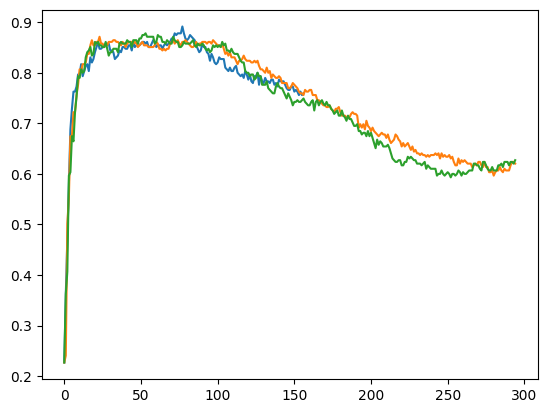

In [40]:
plt.plot(list_score_w_to_d)
plt.plot(list_score_w_to_c)
plt.plot(list_score_w_to_a)


In [44]:
score_in_target_w_to_d, score_in_baseline_w_to_d

(0.9044585987261147, 0.3057324840764331)

In [45]:
score_in_target_w_to_c, score_in_baseline_w_to_c

(0.2840605520926091, 0.1923419412288513)

In [46]:
score_in_target_w_to_a, score_in_baseline_w_to_a

(0.3079331941544885, 0.17536534446764093)

# Entropic regularized optimal transport

In [139]:
def knn_ot(S,S_y,T, T_y, reg):
        #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    
    a = np.repeat(1/S.shape[0], S.shape[0])
    b = np.repeat(1/T.shape[0], T.shape[0])
    M = cdist(S,T)
    M /= np.max(M)
    coupling = ot.sinkhorn(a,b,M, reg)
    Sa = coupling@T
    print(Sa.shape)
    print(T.shape)
    coupling_label = np.zeros_like(coupling)
    maxtrashind = np.argmax(coupling,axis=0)
    for c in range(coupling_label.shape[1]):
        coupling_label[maxtrashind[c],c] = 1

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(Sa, S_y.ravel())
    predicted_label = knn.predict(T)
    
    #transported_target_label = predicted_label@coupling_label

    return  coupling, predicted_label
""" 

    print(coupling.shape)
    Sa = coupling@T
    print(T.shape)
    print(Sa.shape)
    print(T_y.shape)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S, S_y)
    score_in_target = knn.score(Sa, T_y.ravel())
    
    return score_in_target 
    """

' \n\n    print(coupling.shape)\n    Sa = coupling@T\n    print(T.shape)\n    print(Sa.shape)\n    print(T_y.shape)\n    knn = KNeighborsClassifier(n_neighbors=1)\n    knn.fit(S, S_y)\n    score_in_target = knn.score(Sa, T_y.ravel())\n    \n    return score_in_target \n    '

Why is Gamma @ T moving S to T?
Take this gamma matrix as toy example:

0.2 0.0 0.8

0.3 0.7 0.0

0.4 0.3 0.3

First, remember that we move points, so the first row of S is telling us how we move one point of S to T. In the example, the 20% of the first point of S is moved to the first point of T, and 80% of the first point of S is moved to the third point of T.
Second, imagine that T has only one column, this means that it only has one feature, therefore we want a new point of S that takes 20% of the value of the feature from the first point of T and 80% of the value from the third point of T. Therefore we have moved one point of S, and the feature of this new point is the linear combination of the feature in T in the first and third points. 
Finally, if we have more features in T, the new point S has features that are linear combinations of the features in T. The linear combination is given by the values of the rows of gamma. 

NB. Gamma @ T has a dimension of the number of rows of gamma and the number of features in T. Therefore we create as many new points as the rows in gamma, with a number of features determined by the features in T.


(295, 800)
(157, 800)


0.7643312101910829

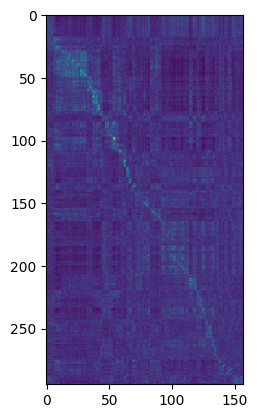

In [162]:
coupling, pred = knn_ot(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf, reg=1)
plt.imshow(coupling)
np.sum(pred== Y_d_surf.ravel())/ len(Y_d_surf)

In [163]:
np.sum(pred== Y_d_surf.ravel())/ len(Y_d_surf)

0.7643312101910829

In [145]:
Y_d_surf.shape

(157, 1)

(array([29., 21., 31., 27., 27., 30., 43., 30., 27., 30.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

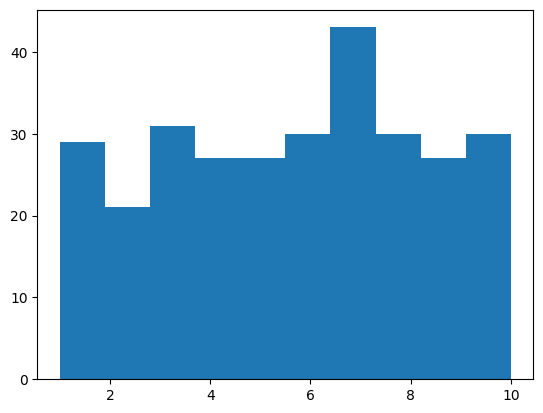

In [135]:
plt.hist(Y_w_surf)

In [79]:
trash_zeros = np.zeros_like(trash)
maxtrashind = np.argmax(trash,axis=1)
for r in range(trash_zeros.shape[0]):
    trash_zeros[r,maxtrashind[r]] = 1

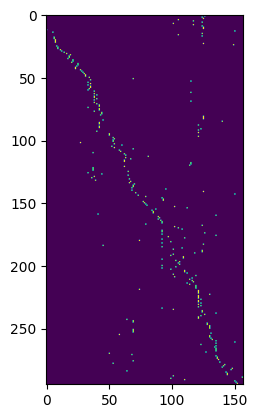

In [81]:
plt.imshow(trash_zeros)

array([ 1.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  1.,  2.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  0.,  2.,  1.,  2.,
        0.,  2.,  1.,  1.,  1.,  2.,  0.,  5.,  2.,  4.,  1.,  4.,  8.,
        1.,  4.,  1.,  8.,  1.,  3.,  2.,  0.,  0.,  0.,  0.,  3.,  0.,
        1.,  4.,  3.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  4.,  2.,  2.,
        2.,  2.,  2.,  3., 10.,  1.,  1.,  0.,  1.,  2.,  0.,  0.,  1.,
        1.,  3.,  1.,  1.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  2.,  1.,
        1., 13.,  2.,  0.,  1.,  0.,  1.,  0.,  4.,  0.,  6.,  3.,  2.,
        0.,  4.,  2.,  0.,  2.,  2.,  4.,  0.,  3.,  0.,  3.,  5.,  2.,
        3.,  1.,  4.,  0., 16.,  0.,  6., 11.,  9.,  3.,  1.,  2.,  0.,
        6.,  2.,  1.,  0.,  1., 10.,  2.,  1.,  1.,  0.,  2.,  1.,  1.,
        1.,  2.,  0.,  0.,  1.,  1.,  1.,  4.,  1.,  1.,  0.,  0.,  0.,
        1.])